# MLP Fine-tuning Notebook

This notebook fine-tunes a pre-trained MLP model by:
1. Loading pre-trained weights from `mlp_dataset1_model.pth`
2. Replacing the final head with a new one for the target dataset
3. Fine-tuning on a new dataset (dataset2 or dataset3)

The backbone layers are loaded from the pre-trained model, and only the head is replaced to match the number of classes in the new dataset.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import copy
import warnings
warnings.filterwarnings('ignore')

# Import the MLP model
from model_art import BackBone, Head, ClassificationModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/giovanniattina/miniconda3/envs/task-vectors/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/giovanniattina/miniconda3/envs/task-vectors/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cpu


## 2. Configuration

Choose the dataset to fine-tune on and set training parameters:

In [2]:
# Configuration
PRETRAINED_MODEL_PATH = "artificial_checkpoints/mlp_model.pth"
FINETUNE_DATASET = "dataset2"  # Change this to "dataset2" or "dataset3"

# Fine-tuning parameters
FINETUNE_LEARNING_RATE = 0.0001  # Lower learning rate for fine-tuning
FINETUNE_BATCH_SIZE = 32
FINETUNE_EPOCHS = 50

# Freezing strategy
FREEZE_BACKBONE = False  # Set to True to freeze backbone layers, False to train all layers

print(f"Pre-trained model: {PRETRAINED_MODEL_PATH}")
print(f"Fine-tune dataset: {FINETUNE_DATASET}")
print(f"Learning rate: {FINETUNE_LEARNING_RATE}")
print(f"Batch size: {FINETUNE_BATCH_SIZE}")
print(f"Epochs: {FINETUNE_EPOCHS}")
print(f"Freeze backbone: {FREEZE_BACKBONE}")

Pre-trained model: artificial_checkpoints/mlp_model.pth
Fine-tune dataset: dataset2
Learning rate: 0.0001
Batch size: 32
Epochs: 50
Freeze backbone: False


## 3. Load Pre-trained Model

Load the pre-trained model weights and examine the architecture:

In [3]:
checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location=device)

In [4]:
checkpoint

{'state_dict': OrderedDict([('block1.block.0.weight',
               tensor([[-0.0020, -0.0109, -0.0057,  ..., -0.0207, -0.0185,  0.0398],
                       [-0.0404,  0.0318,  0.0045,  ...,  0.0011, -0.0261,  0.0225],
                       [ 0.0951, -0.0138, -0.0077,  ...,  0.0340, -0.0215,  0.0525],
                       ...,
                       [-0.0126,  0.0154, -0.0138,  ...,  0.0446, -0.0337, -0.0143],
                       [-0.0765, -0.0279, -0.0242,  ..., -0.0313, -0.0165, -0.0217],
                       [-0.0598, -0.0208, -0.0276,  ...,  0.0035,  0.0026,  0.0087]])),
              ('block1.block.0.bias',
               tensor([-7.0561e-02, -5.9605e-02, -3.0815e-03, -2.6432e-02, -5.6286e-02,
                       -6.3937e-02, -4.0500e-02, -5.0147e-02, -4.0543e-02, -4.9544e-02,
                       -1.1637e-01, -2.5494e-02, -9.7146e-02, -3.2855e-02, -5.1053e-02,
                        3.1534e-03, -6.5355e-02, -8.8213e-02, -7.1006e-02, -5.0629e-02,
               

In [5]:
'state_dict' in checkpoint

True

In [6]:
# Load the pre-trained model checkpoint
try:
    checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location=device)
    print("✓ Successfully loaded pre-trained model checkpoint")
    
    # Check if it's a complete checkpoint or just state dict
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        pretrained_state_dict = checkpoint['state_dict']
        model_config = checkpoint.get('model_config', {})
        training_config = checkpoint.get('training_config', {})
        
        print(f"Pre-trained model config: {model_config}")
        print(f"Original training config: {training_config}")
        
        # Get original model dimensions
        original_input_dim = model_config.get('input_dim', 20)  # Default based on dataset1
        original_output_dim = model_config.get('output_dim', 2)  # Default binary classification
    else:
        # If it's just a state dict
        pretrained_state_dict = checkpoint
        # Infer dimensions from the state dict
        original_input_dim = pretrained_state_dict['block1.block.0.weight'].shape[1]
        original_output_dim = pretrained_state_dict['head.2.weight'].shape[0]
    
    print(f"Original model - Input dim: {original_input_dim}, Output dim: {original_output_dim}")
    
except FileNotFoundError:
    print(f"❌ Error: Could not find pre-trained model at {PRETRAINED_MODEL_PATH}")
    print("Please ensure the model file exists and try again.")
except Exception as e:
    print(f"❌ Error loading pre-trained model: {e}")

✓ Successfully loaded pre-trained model checkpoint
Pre-trained model config: {'input_dim': 512, 'output_dim': 10}
Original training config: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Original model - Input dim: 512, Output dim: 10


## 4. Load Fine-tuning Dataset

Load the new dataset for fine-tuning:

In [7]:
# Load fine-tuning dataset
finetune_train_path = f"artificial_datasets/{FINETUNE_DATASET}_train.csv"
finetune_test_path = f"artificial_datasets/{FINETUNE_DATASET}_test.csv"

print(f"Loading fine-tuning dataset: {FINETUNE_DATASET}")
print(f"Train file: {finetune_train_path}")
print(f"Test file: {finetune_test_path}")

try:
    # Load training data
    finetune_train_data = pd.read_csv(finetune_train_path)
    print(f"✓ Training data shape: {finetune_train_data.shape}")
    
    # Load validation data
    finetune_val_data = pd.read_csv(finetune_test_path)
    print(f"✓ Validation data shape: {finetune_val_data.shape}")
    
    # Examine the data
    print(f"\nDataset info:")
    print(f"Feature columns: {finetune_train_data.columns[:-1].tolist()}")
    print(f"Target column: {finetune_train_data.columns[-1]}")
    
    # Check number of classes in new dataset
    unique_classes = sorted(finetune_train_data['target'].unique())
    new_num_classes = len(unique_classes)
    new_input_dim = finetune_train_data.shape[1] - 1  # Exclude target column
    
    print(f"Unique classes: {unique_classes}")
    print(f"Number of classes: {new_num_classes}")
    print(f"Input dimension: {new_input_dim}")
    
    # Check class distribution
    print(f"\nClass distribution in training set:")
    class_counts = finetune_train_data['target'].value_counts().sort_index()
    for cls, count in class_counts.items():
        print(f"  Class {cls}: {count} samples ({count/len(finetune_train_data)*100:.1f}%)")
        
except FileNotFoundError as e:
    print(f"❌ Error: Could not find dataset files. Please check the dataset name.")
    print(f"Available datasets: dataset1, dataset2, dataset3")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

Loading fine-tuning dataset: dataset2
Train file: artificial_datasets/dataset2_train.csv
Test file: artificial_datasets/dataset2_test.csv
✓ Training data shape: (9600, 513)
✓ Validation data shape: (2400, 513)

Dataset info:
Feature columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123',

In [8]:
# Prepare data for fine-tuning
X_finetune_train = finetune_train_data.iloc[:, :-1].values
y_finetune_train = finetune_train_data.iloc[:, -1].values

X_finetune_val = finetune_val_data.iloc[:, :-1].values
y_finetune_val = finetune_val_data.iloc[:, -1].values

# Convert to torch tensors
X_finetune_train_tensor = torch.FloatTensor(X_finetune_train).to(device)
y_finetune_train_tensor = torch.LongTensor(y_finetune_train).to(device)

X_finetune_val_tensor = torch.FloatTensor(X_finetune_val).to(device)
y_finetune_val_tensor = torch.LongTensor(y_finetune_val).to(device)

print(f"Fine-tuning data tensors:")
print(f"  Training features: {X_finetune_train_tensor.shape}")
print(f"  Training targets: {y_finetune_train_tensor.shape}")
print(f"  Validation features: {X_finetune_val_tensor.shape}")
print(f"  Validation targets: {y_finetune_val_tensor.shape}")

# Create DataLoaders
finetune_train_dataset = TensorDataset(X_finetune_train_tensor, y_finetune_train_tensor)
finetune_val_dataset = TensorDataset(X_finetune_val_tensor, y_finetune_val_tensor)

finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=FINETUNE_BATCH_SIZE, shuffle=True)
finetune_val_loader = DataLoader(finetune_val_dataset, batch_size=FINETUNE_BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(finetune_train_loader)}")
print(f"  Validation batches: {len(finetune_val_loader)}")

Fine-tuning data tensors:
  Training features: torch.Size([9600, 512])
  Training targets: torch.Size([9600])
  Validation features: torch.Size([2400, 512])
  Validation targets: torch.Size([2400])

DataLoaders created:
  Training batches: 300
  Validation batches: 75


## 5. Create Fine-tuned Model with New Head

Create a model with pre-trained backbone and new head for the target dataset:

In [9]:
# Create new model with the same input dimension but new output dimension
print(f"Creating fine-tuned model...")
print(f"  Input dimension: {new_input_dim}")
print(f"  Output dimension: {new_num_classes}")

# Create the fine-tuned model
finetuned_backbone = BackBone(input_dim=new_input_dim).to(device)
finetuned_head = Head(input_dim=finetuned_backbone.get_output_dim(), output_dim=new_num_classes).to(device)
finetuned_model = ClassificationModel(backbone=finetuned_backbone, head=finetuned_head).to(device)

print(f"\nModel architecture:")
print(finetuned_model)

# Load the pre-trained backbone weights (excluding the head)
print(f"\nLoading pre-trained weights...")
model_dict = finetuned_model.state_dict()
pretrained_dict = {}

# Filter out the head layers and load only backbone layers
for k, v in pretrained_state_dict.items():
    if k.startswith('layers.') and k in model_dict:
        # Only load if dimensions match
        if model_dict[k].shape == v.shape:
            pretrained_dict[k] = v
            print(f"  ✓ Loaded: {k} {v.shape}")
        else:
            print(f"  ✗ Skipped: {k} (shape mismatch: {model_dict[k].shape} vs {v.shape})")
    elif k.startswith('head.'):
        print(f"  ⚠ Skipped head layer: {k} (will be randomly initialized)")

# Update the model dict with pre-trained weights
model_dict.update(pretrained_dict)
finetuned_model.load_state_dict(model_dict)

print(f"\n✓ Successfully loaded {len(pretrained_dict)} pre-trained layers")
print(f"✓ Head layers initialized randomly for {new_num_classes} classes")

# Freeze backbone layers if specified
if FREEZE_BACKBONE:
    print(f"\n🔒 Freezing backbone layers...")
    for name, param in finetuned_model.named_parameters():
        if name.startswith('layers.'):
            param.requires_grad = False
            print(f"  Frozen: {name}")
        else:
            print(f"  Trainable: {name}")
else:
    print(f"\n🔓 All layers will be trained (no freezing)")

# Count parameters
total_params = sum(p.numel() for p in finetuned_model.parameters())
trainable_params = sum(p.numel() for p in finetuned_model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nParameter summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {frozen_params:,}")

Creating fine-tuned model...
  Input dimension: 512
  Output dimension: 5

Model architecture:
ClassificationModel(
  (backbone): BackBone(
    (block1): MLPBlock(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=512, bias=True)
        (7): ReLU()
        (8): Linear(in_features=512, out_features=512, bias=True)
        (9): ReLU()
      )
    )
    (transition): Linear(in_features=512, out_features=256, bias=True)
    (block2): MLPBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
     

## 6. Fine-tune the Model

Train the model on the new dataset:

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(finetuned_model.parameters(), lr=FINETUNE_LEARNING_RATE)

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting fine-tuning...")
print(f"Total trainable parameters: {trainable_params:,}")
print(f"  Learning rate: {FINETUNE_LEARNING_RATE}")
print(f"  Batch size: {FINETUNE_BATCH_SIZE}")
print(f"  Epochs: {FINETUNE_EPOCHS}")
print(f"  Freeze backbone: {FREEZE_BACKBONE}")
print("-" * 60)

best_val_accuracy = 0.0
best_model_state = None

# Fine-tuning loop
for epoch in range(FINETUNE_EPOCHS):
    # Training phase
    finetuned_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in finetune_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = finetuned_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    # Validation phase
    finetuned_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in finetune_val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = finetuned_model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    # Calculate metrics
    epoch_train_loss = train_loss / len(finetune_train_loader)
    epoch_train_acc = 100 * train_correct / train_total
    epoch_val_loss = val_loss / len(finetune_val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    # Store metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # Save best model
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        best_model_state = copy.deepcopy(finetuned_model.state_dict())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{FINETUNE_EPOCHS}]:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

# Load best model
finetuned_model.load_state_dict(best_model_state)

print("-" * 60)
print("Fine-tuning completed!")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Starting fine-tuning...
Total trainable parameters: 1,807,109
  Learning rate: 0.0001
  Batch size: 32
  Epochs: 50
  Freeze backbone: False
------------------------------------------------------------
Epoch [1/50]:
  Train Loss: 1.4912, Train Acc: 30.52%
  Val Loss: 1.3320, Val Acc: 39.88%
Epoch [10/50]:
  Train Loss: 0.1289, Train Acc: 95.74%
  Val Loss: 2.2067, Val Acc: 58.08%
Epoch [20/50]:
  Train Loss: 0.0515, Train Acc: 98.51%
  Val Loss: 2.4307, Val Acc: 61.33%
Epoch [30/50]:
  Train Loss: 0.0251, Train Acc: 99.51%
  Val Loss: 2.4747, Val Acc: 63.33%
Epoch [40/50]:
  Train Loss: 0.0228, Train Acc: 99.44%
  Val Loss: 2.2200, Val Acc: 65.38%
Epoch [50/50]:
  Train Loss: 0.0119, Train Acc: 99.64%
  Val Loss: 2.4203, Val Acc: 65.79%
------------------------------------------------------------
Fine-tuning completed!
Best validation accuracy: 67.17%


## 6. Evaluate Fine-tuned Model

Final Validation Accuracy: 0.6717

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       480
           1       0.76      0.77      0.77       479
           2       0.68      0.71      0.69       479
           3       0.61      0.57      0.59       479
           4       0.69      0.64      0.66       483

    accuracy                           0.67      2400
   macro avg       0.67      0.67      0.67      2400
weighted avg       0.67      0.67      0.67      2400



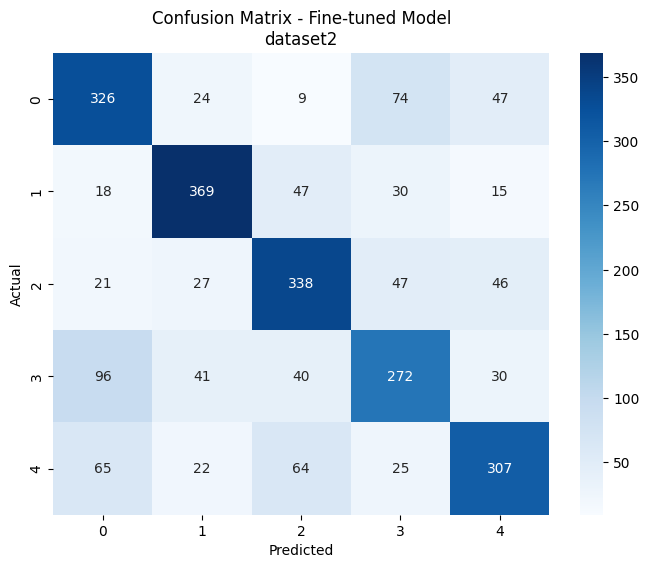


Per-class accuracy:
Class 0: 0.6792
Class 1: 0.7704
Class 2: 0.7056
Class 3: 0.5678
Class 4: 0.6356


In [11]:
# Evaluate on validation set
finetuned_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in finetune_val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = finetuned_model(batch_X)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Calculate final metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

final_accuracy = accuracy_score(all_targets, all_predictions)
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions))

# Confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Fine-tuned Model\n{FINETUNE_DATASET}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class accuracy
unique_classes = sorted(list(set(all_targets)))
print(f"\nPer-class accuracy:")
for cls in unique_classes:
    cls_mask = np.array(all_targets) == cls
    cls_acc = accuracy_score(np.array(all_targets)[cls_mask], np.array(all_predictions)[cls_mask])
    print(f"Class {cls}: {cls_acc:.4f}")

## 7. Visualize Training Progress

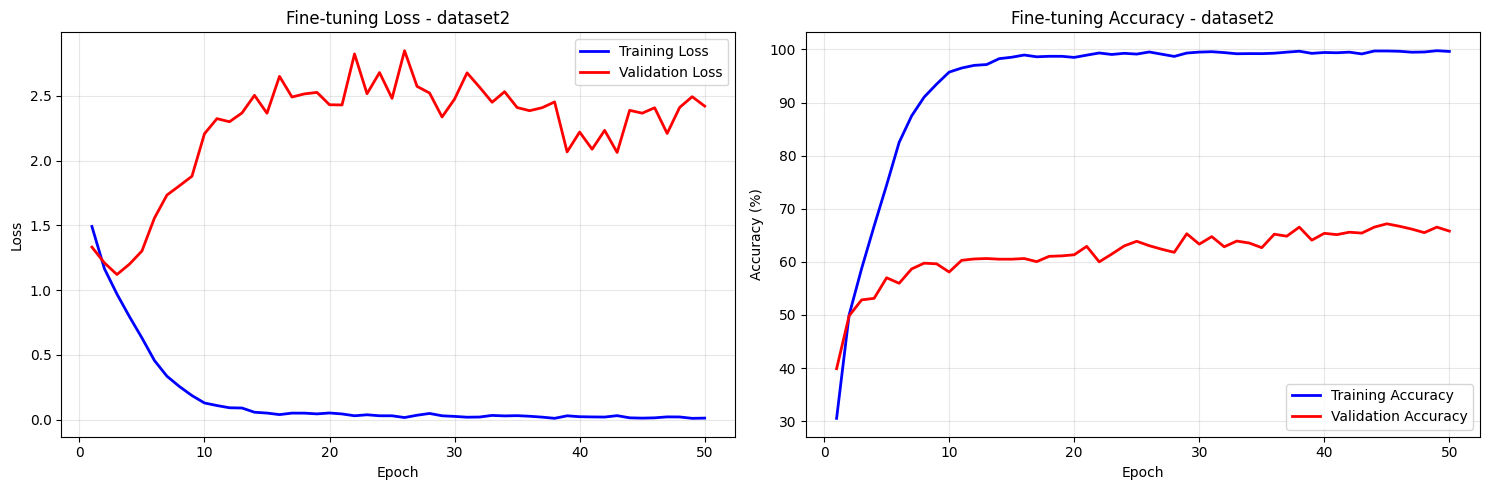

Best validation accuracy: 67.17% at epoch 45

Fine-tuning Summary:
- Dataset: dataset2
- Learning Rate: 0.0001
- Batch Size: 32
- Epochs: 50
- Backbone Frozen: False
- Trainable Parameters: 1,807,109
- Final Validation Accuracy: 65.79%
- Best Validation Accuracy: 67.17%


In [12]:
# Plot training progress
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, FINETUNE_EPOCHS + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, FINETUNE_EPOCHS + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title(f'Fine-tuning Loss - {FINETUNE_DATASET}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, FINETUNE_EPOCHS + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, FINETUNE_EPOCHS + 1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title(f'Fine-tuning Accuracy - {FINETUNE_DATASET}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_val_acc_epoch = np.argmax(val_accuracies) + 1
best_val_acc = max(val_accuracies)
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_val_acc_epoch}")

# Training summary
print(f"\nFine-tuning Summary:")
print(f"- Dataset: {FINETUNE_DATASET}")
print(f"- Learning Rate: {FINETUNE_LEARNING_RATE}")
print(f"- Batch Size: {FINETUNE_BATCH_SIZE}")
print(f"- Epochs: {FINETUNE_EPOCHS}")
print(f"- Backbone Frozen: {FREEZE_BACKBONE}")
print(f"- Trainable Parameters: {trainable_params:,}")
print(f"- Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"- Best Validation Accuracy: {best_val_acc:.2f}%")

## 8. Save Fine-tuned Model

In [14]:
import os
from datetime import datetime

In [15]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"artificial_checkpoints/mlp_model_{FINETUNE_DATASET}.pth"

# Save model state dict and training info
torch.save({
    'state_dict': finetuned_model.backbone.state_dict(),
    'head_state_dict': finetuned_model.head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_config': {
        'input_dim': new_input_dim,
        'output_dim': new_num_classes
    },
    'training_config': {
        'learning_rate': FINETUNE_LEARNING_RATE,
        'batch_size': FINETUNE_BATCH_SIZE,
        'num_epochs': FINETUNE_EPOCHS
    }
}, model_filename)

print(f"Model saved to: {model_filename}")


Model saved to: artificial_checkpoints/mlp_model_dataset2.pth
